
This notebook uses the output of the rule
--- 75_assm_stats.smk::dump_suppl_tables_contiguity
as input, and produces panels for figure 1.

Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/assm_stats
Working directory:  /home/local/work/data/sig_chrY/paper
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


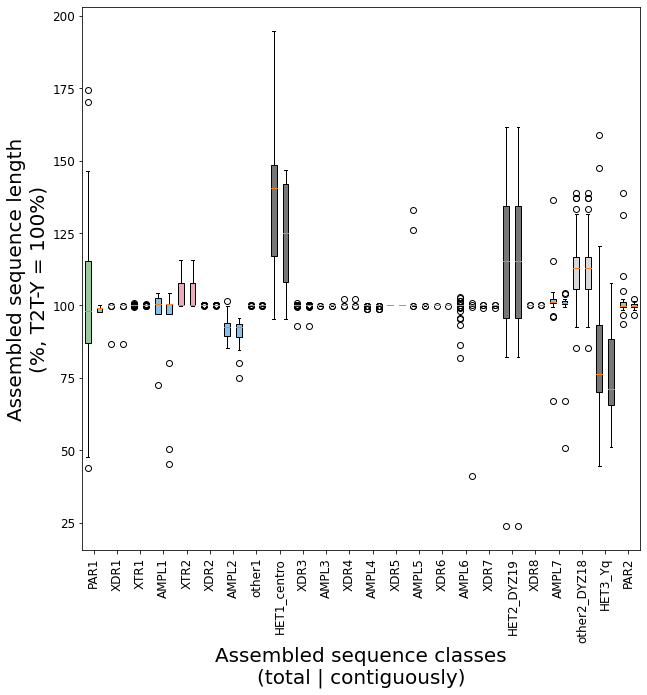

In [30]:
%matplotlib inline
import pathlib as pl

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

desc="""
This notebook uses the output of the rule
--- 75_assm_stats.smk::dump_suppl_tables_contiguity
as input, and produces panels for figure 1.
"""

save_plots = True

print(desc)

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper').resolve(strict=True)
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

t2t_file = wd_dir / pl.Path('annotation_tables', 'T2T.chrY-seq-classes.tsv')
t2t = pd.read_csv(t2t_file, sep='\t', header=0)
seqclass_to_idx = dict((row.name, row.Index) for row in t2t.itertuples())

table_file = wd_dir / pl.Path('stats', 'contiguity', 'lenassm-total-seqcls.by-contig.HIFIRW.ONTUL.na.chrY.flat.tsv')
table_file = table_file.resolve(strict=True)

table = pd.read_csv(table_file, sep='\t', comment='#', header=0)

total_length = []
drop_dup = ['sample', 'seqclass', 'total_assm_length_pct']
boxes_total_length = table[drop_dup].drop_duplicates(drop_dup, inplace=False).groupby('seqclass')
for seqclass, assm_len in boxes_total_length:
    pct_values = np.zeros(44, dtype=np.float16)
    pct_values[:assm_len.shape[0]] = assm_len['total_assm_length_pct'].values
    seqclass_idx = seqclass_to_idx[seqclass]
    total_length.append((seqclass_idx, assm_len['total_assm_length_pct'].values))

contiguous_length = []
select_cols = ['sample', 'seqclass', 'contig_assm_length_pct']
subset = table.loc[table['is_contiguous'] > 0, select_cols].copy()
aggregated = subset.groupby(['sample', 'seqclass'])['contig_assm_length_pct'].sum()
for seqclass, assm_len in aggregated.groupby('seqclass'):
    pct_values = np.zeros(44, dtype=np.float16)
    pct_values[:assm_len.shape[0]] = assm_len.values
    seqclass_idx = seqclass_to_idx[seqclass]
    contiguous_length.append((seqclass_idx, assm_len.values))

fig, ax = plt.subplots(figsize=(10,10))
fig_name = 'assm_pct_length_seqclasses'

total_pos = np.arange(0,t2t.shape[0] * 2, 2)
tbox = ax.boxplot(
    [t[1] for t in sorted(total_length)],
    positions=total_pos,
    patch_artist=True
)

for row, box in zip(t2t.itertuples(), tbox['boxes']):
    box.set_facecolor((row.red, row.green, row.blue))

cbox = ax.boxplot(
    [t[1] for t in sorted(contiguous_length)],
    positions=total_pos + 1,
    patch_artist=True
)

for row, box in zip(t2t.itertuples(), cbox['boxes']):
    box.set_facecolor((row.red, row.green, row.blue))

ax.set_xticks(total_pos + 0.5)
ax.set_xticklabels(t2t['name'].values, fontsize=14, rotation=90)

ax.set_xlabel('Assembled sequence classes\n(total | contiguously)', fontsize=20)
ax.set_ylabel('Assembled sequence length\n(%, T2T-Y = 100%)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)

#leg1 = ax.legend(handles=marker_legend, loc='best', fontsize=18)
#leg1.set_bbox_to_anchor((1.4, 0.5), transform = ax.transAxes)

if save_plots:
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.png'),
        dpi=150, bbox_inches='tight', transparent=False,
        bbox_extra_artists=[]
    )
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.pdf'),
        bbox_inches='tight', transparent=False,
        bbox_extra_artists=[]
    )
